# ENV717 - S2022
A4
Q1. c

In [1]:
##################################################################################################
#       ENV717 - S2022                                                                           #                            
#       This script explores eGRID and 
#       finds the power supply curve from ISO NEW ENGLAND's baseload generators                #
##################################################################################################
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### THIS IS NOT THE MOST ELEGANT SOLUTION OF THIS ASSIGNMENT. MANY OF THE LINES OF CODE COULD HAVE BEEN OBVIATED IF WE 
### HAD DEFINED SOME BETTER DATA STRUCTURES TO HANDLE PLANTS BY TYPE AND HAD DEFINED THE FUNCTIONS THAT WILL BE USED 
### MORE THAN ONCE.

##################################################################################################################
## 1. Read eGRID19 file                                                                                          #
##         Read the PLNT19 sheet of the excel file into a pandas DataFrame.                                      #
##         A DataFrame is a two-dimensional labeled data structure with columns of potentially different types   #
##         Specify that the headers are on the second row of the excel file (i.e., row 1 in Python)              #
## 2. Confirm we read all columns by printing the first five rows                                                #
###################################################################################################################
egrid=pd.read_excel("egrid2019_data.xlsx",sheet_name="PLNT19",keep_default_na=False,header=1)

In [90]:
## 4. Extract the plants using BACODE
subset=egrid[egrid['BACODE']=="ISNE"]
ISOName="ISO New England"
print("There are",len(subset),"plants in ", ISOName)

There are 1009 plants in  ISO New England


In [92]:
## To find the capacity and generation by fuel we first need to findout the names of fuel categories PLFUELCT in the DataFrame
subset.PLFUELCT.unique()

array(['SOLAR', 'GAS', 'OIL', 'HYDRO', 'BIOMASS', 'OFSL', 'NUCLEAR', '',
       'WIND', 'OTHF', 'COAL'], dtype=object)

In [93]:
## 6. Q1a. Find the total installed capacity in MW and total electricity generation from power plants of different fuels
## and as a percentage of PJM capacity and generation

## Note this is not the most elegant way to calculate these numbers, but for now it is ok.
biomass=subset[subset['PLFUELCT']=="BIOMASS"]
coal=subset[subset['PLFUELCT']=="COAL"]
gas=subset[subset['PLFUELCT']=="GAS"]
geothermal=subset[subset['PLFUELCT']=="GEOTHERMAL"]
hydro=subset[subset['PLFUELCT']=="HYDRO"]
nuclear=subset[subset['PLFUELCT']=="NUCLEAR"]
oil=subset[subset['PLFUELCT']=="OIL"]
otherff=subset[subset['PLFUELCT']=="OFSL"]
solar=subset[subset['PLFUELCT']=="SOLAR"]
wind=subset[subset['PLFUELCT']=="WIND"]
other=subset[subset['PLFUELCT']=="OTHF"]

In [94]:
#7. Q2a. Find the total installed capacity of a subset of PJM plants that meet these requirements:
# Fuel = Coal Gas Nuclear Hydro Oil biomass wind solar
# Plant Capacity Factor >= 0.01
# Plant Nameplate capacity >= 1 MW
# before filtering, need to make sure the type of CAPFAC is numeric
subset["CAPFAC"].dtype

dtype('O')

In [95]:
# Change CAPFAC to numeric
subset.loc[:,"CAPFAC"]=pd.to_numeric(subset["CAPFAC"])

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [96]:
# We will filter by one criteria each time to see how many plants are excluded at each time
# but you can combine the criteria using &
subsetSub=subset[(subset.PLFUELCT=="GAS")|(subset.PLFUELCT=="COAL")|(subset.PLFUELCT=="NUCLEAR")|(subset.PLFUELCT=="OIL")|(subset.PLFUELCT=="HYDRO")|(subset.PLFUELCT=="BIOMASS")|(subset.PLFUELCT=="SOLAR")|(subset.PLFUELCT=="WIND")]
print("The subset contains",len(subsetSub),"plants")

The subset contains 967 plants


In [98]:
subsetSub=subsetSub[subsetSub.CAPFAC>0.01]  # This excludes plants that have blanks as CF (which is ok)
print("The subset contains",len(subsetSub),"plants")

The subset contains 744 plants


In [99]:
subsetSubCap=subsetSub.NAMEPCAP.sum()
print("The total installed capacity of",ISOName,"plants with more than 1% of CF and more than 1 MW of nameplate is",'%.2f' %subsetSubCap,"MW")

The total installed capacity of ISO New England plants with more than 1% of CF and more than 1 MW of nameplate is 33340.60 MW


In [100]:
#8. Q2c. Plot the supply curve assuming all plants are those in the subsetSub
# Before proceeding let's take just the columns that will be used - we need CAPFAC
subsetSub=subsetSub.loc[:,["PNAME","NAMEPCAP","PLFUELCT","PLHTIAN","PLNGENAN","PLCO2EQA","CAPFAC"]]
subsetSub.head(5)

,PNAME,NAMEPCAP,PLFUELCT,PLHTIAN,PLNGENAN,PLCO2EQA,CAPFAC
2410,ALDI DC 2,1.2,SOLAR,,1683,,0.16010
2412,"Algonquin Power Windsor Locks, LLC",71,GAS,31384.936,124109.56,1955.479,0.19955
2414,Antares-GRE 314 East Lyme LLC,4,SOLAR,,5868,,0.16747
2415,Backus Microgrid Project,10.4,OIL,10056,991,824.013,0.01088
2416,Barrett Farm Solar - Phase I,1.7,SOLAR,,2710,,0.18198


In [101]:
# check the type of PLHTIAN
subsetSub["PLHTIAN"].dtype

dtype('O')

In [102]:
# convert PLHTIAN to numeric
subsetSub["PLHTIAN"]=pd.to_numeric(subsetSub["PLHTIAN"])
subsetSub["PLHTIAN"].dtype

dtype('float64')

In [103]:
# To build the supply curve we need to find the marginal cost of each plant first
# will assume marginal cost for coal/gas plants is fuel cost only
# Need to calculate fuel cost by multiplying heat-rate and fuel price
# First calculate HEAT RATE -->HEAT RATE (MMBTU/MWH) = ANNUAL HEAT INPUT (MMBTU)/ANNUAL GENERATION (MWH)
# Add heat-rate as a new column to pjmSub
subsetSub["HEATRATE"]=subsetSub["PLHTIAN"] / subsetSub["PLNGENAN"]

In [104]:
# let's check that we added the new column heat rate by looking at the first 5 rows
#The non-thermal plants (e.g., nucclear did not consume BTUs as fuel so the heatrate will be meaningless but that is ok)
subsetSub.head(5)

,PNAME,NAMEPCAP,PLFUELCT,PLHTIAN,PLNGENAN,PLCO2EQA,CAPFAC,HEATRATE
2410,ALDI DC 2,1.2,SOLAR,NaN,1683,,0.16010,NaN
2412,"Algonquin Power Windsor Locks, LLC",71,GAS,31384.936,124109.56,1955.479,0.19955,0.252881
2414,Antares-GRE 314 East Lyme LLC,4,SOLAR,NaN,5868,,0.16747,NaN
2415,Backus Microgrid Project,10.4,OIL,10056.000,991,824.013,0.01088,10.147326
2416,Barrett Farm Solar - Phase I,1.7,SOLAR,NaN,2710,,0.18198,NaN


In [105]:
# Now lets create a column of marginal cost in $MWh
# Initialize the new column in zeros
subsetSub["MARGCOST"]=0      
#lets create also a new column with adjusted capacity, and initialize it in 0
subsetSub["ADJCAP"]=0
subsetSub.head(5)

,PNAME,NAMEPCAP,PLFUELCT,PLHTIAN,PLNGENAN,PLCO2EQA,CAPFAC,HEATRATE,MARGCOST,ADJCAP
2410,ALDI DC 2,1.2,SOLAR,NaN,1683,,0.16010,NaN,0,0
2412,"Algonquin Power Windsor Locks, LLC",71,GAS,31384.936,124109.56,1955.479,0.19955,0.252881,0,0
2414,Antares-GRE 314 East Lyme LLC,4,SOLAR,NaN,5868,,0.16747,NaN,0,0
2415,Backus Microgrid Project,10.4,OIL,10056.000,991,824.013,0.01088,10.147326,0,0
2416,Barrett Farm Solar - Phase I,1.7,SOLAR,NaN,2710,,0.18198,NaN,0,0


In [106]:
coal_price=2.02 # $/MMBTU
gas_price=2.89 # $/MMBTU
nuclear_mc=9 # $/MWh
hydro_mc=6 # $/MWh
oil_price=15 #$MMBTU
biomass_price=11.69 #$/MMBTU
wind_mc=0
solar_mc=0
# walk through all the rows of plants and change the MARGCOST and ADJCAP depending on fuel and the A

for i in range(0,len(subsetSub)):
    if subsetSub.iloc[i,2]=="COAL":                     # Remember to use == to compare and = to assign
        subsetSub.iloc[i,8]=coal_price*subsetSub.iloc[i,7] # MARGCOST is column 8 because python starts counting from 0
        subsetSub.iloc[i,9]=subsetSub.iloc[i,1]
    elif subsetSub.iloc[i,2]=="GAS":                     
         subsetSub.iloc[i,8]=gas_price*subsetSub.iloc[i,7]
         subsetSub.iloc[i,9]=subsetSub.iloc[i,1]
    elif subsetSub.iloc[i,2]=="NUCLEAR":                     
         subsetSub.iloc[i,8]=nuclear_mc 
         subsetSub.iloc[i,9]=subsetSub.iloc[i,1]
    elif subsetSub.iloc[i,2]=="HYDRO":                     
         subsetSub.iloc[i,8]=hydro_mc
         subsetSub.iloc[i,9]=subsetSub.iloc[i,1]
    elif subsetSub.iloc[i,2]=="BIOMASS":                     
         subsetSub.iloc[i,8]=biomass_price*subsetSub.iloc[i,7]
         subsetSub.iloc[i,9]=subsetSub.iloc[i,1]
    elif subsetSub.iloc[i,2]=="OIL":                    
         subsetSub.iloc[i,8]=oil_price*subsetSub.iloc[i,7] 
         subsetSub.iloc[i,9]=subsetSub.iloc[i,1]
    elif subsetSub.iloc[i,2]=="WIND":                    
         subsetSub.iloc[i,8]=wind_mc 
         subsetSub.iloc[i,9]=subsetSub.iloc[i,1]*subsetSub.iloc[i,6]
    else:                    ##i.e., solar
         subsetSub.iloc[i,8]=solar_mc
         subsetSub.iloc[i,9]=subsetSub.iloc[i,1]*subsetSub.iloc[i,6]
subsetSub.head(5)

,PNAME,NAMEPCAP,PLFUELCT,PLHTIAN,PLNGENAN,PLCO2EQA,CAPFAC,HEATRATE,MARGCOST,ADJCAP
2410,ALDI DC 2,1.2,SOLAR,NaN,1683,,0.16010,NaN,0.000000,0.192120
2412,"Algonquin Power Windsor Locks, LLC",71,GAS,31384.936,124109.56,1955.479,0.19955,0.252881,0.730826,71.000000
2414,Antares-GRE 314 East Lyme LLC,4,SOLAR,NaN,5868,,0.16747,NaN,0.000000,0.669880
2415,Backus Microgrid Project,10.4,OIL,10056.000,991,824.013,0.01088,10.147326,152.209889,10.400000
2416,Barrett Farm Solar - Phase I,1.7,SOLAR,NaN,2710,,0.18198,NaN,0.000000,0.309366


In [107]:
# Now create three new datasets of baseload plants with the new columns
coal2=subsetSub[subsetSub["PLFUELCT"]=="COAL"]
gas2=subsetSub[subsetSub["PLFUELCT"]=="GAS"]
nuclear2=subsetSub[subsetSub["PLFUELCT"]=="NUCLEAR"]
oil2=subsetSub[subsetSub["PLFUELCT"]=="OIL"]
hydro2=subsetSub[subsetSub["PLFUELCT"]=="HYDRO"]
biomass2=subsetSub[subsetSub["PLFUELCT"]=="BIOMASS"]
solar2=subsetSub[subsetSub["PLFUELCT"]=="SOLAR"]
wind2=subsetSub[subsetSub["PLFUELCT"]=="WIND"]
# now sort all the plants in ASCENDING order by MARGCOST using sort_values
subsetSubSorted=subsetSub.sort_values("MARGCOST")
# now create a column with the cummulative capacity [MW] offered at that MARGCOST or less and initialize in zero
subsetSubSorted["CUMCAP"]=0
subsetSubSorted.head(5)

,PNAME,NAMEPCAP,PLFUELCT,PLHTIAN,PLNGENAN,PLCO2EQA,CAPFAC,HEATRATE,MARGCOST,ADJCAP,CUMCAP
2410,ALDI DC 2,1.2,SOLAR,NaN,1683,,0.16010,NaN,0.0,0.192120,0
4802,"Solten Plainville 6000, LLC",4.9,SOLAR,NaN,7536,,0.17557,NaN,0.0,0.860293,0
4798,Smith & Wesson at Springfield MA PV,1.9,SOLAR,NaN,2653,,0.15940,NaN,0.0,0.302860,0
4797,SJA Solar LLC-Solterra Monastery CSG,20.1,SOLAR,NaN,23374,,0.13275,NaN,0.0,2.668275,0
4795,Silver Lake Solar Photovoltaic Facility,1.8,SOLAR,NaN,1857,,0.11777,NaN,0.0,0.211986,0


In [108]:
# The first row of the CUMCAP column is just the ADJCAP of that plant (in that row)
subsetSubSorted.iloc[0,10]=subsetSubSorted.iloc[0,9]
# Now walk through all the rows adding the cumulative capacity. Start at row 1 since row 0 has already the right CUMCAP
for i in range (1,len(subsetSubSorted)):  
               subsetSubSorted.iloc[i,10]=subsetSubSorted.iloc[i-1,10]+subsetSubSorted.iloc[i,9]
#Lets find the total installed power capacity. The last value in the CUMCAP column is the maximum demand that can be served
subsetSubSorted.tail(10)

,PNAME,NAMEPCAP,PLFUELCT,PLHTIAN,PLNGENAN,PLCO2EQA,CAPFAC,HEATRATE,MARGCOST,ADJCAP,CUMCAP
4754,"Pinetree Power Fitchburg, LLC",18,BIOMASS,1819010.875,91658,4124.081,0.58129,19.845631,231.995430,18.0,31148.162693
7565,Wheelabrator Concord Facility,14,BIOMASS,1978210.125,99344,113252.839,0.81005,19.912729,232.779799,14.0,31162.162693
5138,Penobscot Energy Recovery,25.3,BIOMASS,1719223.000,85303,99563.505,0.38489,20.154309,235.603869,25.3,31187.462693
4897,Wheelabrator North Andover,40.3,BIOMASS,4412512.250,218375,252617.407,0.61858,20.206124,236.209585,40.3,31227.762693
4898,Wheelabrator Saugus,53.7,BIOMASS,3852075.750,180847,220535.181,0.38444,21.300192,248.999240,53.7,31281.462693
4603,GRS Fall River,7.3,BIOMASS,351579.000,16361,0.001,0.25585,21.488845,251.204603,7.3,31288.762693
2449,CT Resource Rec Authority Facility,90,BIOMASS,5464231.250,252925,312898.956,0.32081,21.604156,252.552588,90.0,31378.762693
5149,Regional Waste Systems,13.3,BIOMASS,1785627.875,79415,102246,0.68163,22.484768,262.846941,13.3,31392.062693
4755,Pioneer Valley Resource Recovery,9.4,BIOMASS,1044714.000,33448,60097.424,0.40620,31.233975,365.125169,9.4,31401.462693
5128,MMWAC Resource Recovery Facility,5,BIOMASS,748706.000,16100,43038.482,0.36758,46.503478,543.625661,5.0,31406.462693


In [109]:

print("The maximum demand that can be served in", ISOName,"with the power plants contained in the PLNT19 tab of eGRID2019, that had a capacity of more than 1 MW and a CF f more than 1%, INCLUDING WIND AND SOLAR derated at their 2019 capacity factor is    ", '%.2f' %subsetSubSorted.iloc[len(subsetSubSorted)-1,10], "MW")

The maximum demand that can be served in ISO New England with the power plants contained in the PLNT19 tab of eGRID2019, that had a capacity of more than 1 MW and a CF f more than 1%, INCLUDING WIND AND SOLAR derated at their 2019 capacity factor is     31406.46 MW


In [110]:
# Now create three new datasets of coal and gas with the new columns MARGCOST and CUMCAP sorted so we can differentiate them
# in the plot
coalSorted=subsetSubSorted[subsetSubSorted["PLFUELCT"]=="COAL"]
gasSorted=subsetSubSorted[subsetSubSorted["PLFUELCT"]=="GAS"]
nuclearSorted=subsetSubSorted[subsetSubSorted["PLFUELCT"]=="NUCLEAR"]
oilSorted=subsetSubSorted[subsetSubSorted["PLFUELCT"]=="OIL"]
hydroSorted=subsetSubSorted[subsetSubSorted["PLFUELCT"]=="HYDRO"]
bioSorted=subsetSubSorted[subsetSubSorted["PLFUELCT"]=="BIOMASS"]
windSorted=subsetSubSorted[subsetSubSorted["PLFUELCT"]=="WIND"]
solarSorted=subsetSubSorted[subsetSubSorted["PLFUELCT"]=="SOLAR"]

In [111]:
bioSorted.head(5)

,PNAME,NAMEPCAP,PLFUELCT,PLHTIAN,PLNGENAN,PLCO2EQA,CAPFAC,HEATRATE,MARGCOST,ADJCAP,CUMCAP
4526,Deer Island Treatment,85,BIOMASS,218526.698,43366.55,1617.463,0.05824,5.039061,58.906625,85.0,27817.262693
7563,UNH 7.9 MW Plant,7.9,BIOMASS,261545.814,51648,3761.652,0.74632,5.064007,59.198237,7.9,27825.162693
5164,Somerset Plant,107.1,BIOMASS,2951756.118,531715,31454.329,0.56674,5.551388,64.895722,107.1,29757.262693
5065,Androscoggin Mill,80,BIOMASS,2152056.213,387253,7983.59,0.55259,5.557236,64.964086,80.0,29837.262693
11309,Middlebury College,1.6,BIOMASS,19050.523,3395,658.936,0.24222,5.611347,65.596646,1.6,29838.862693


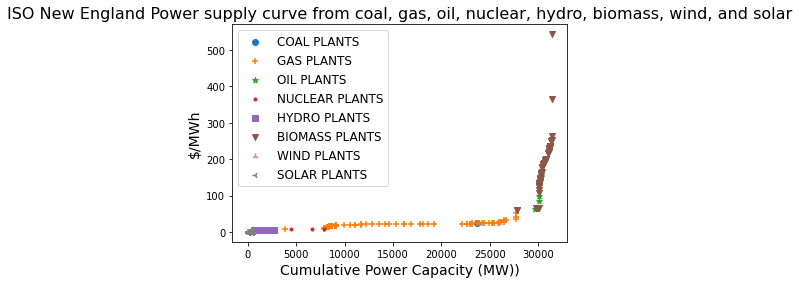

In [112]:
plt.scatter(coalSorted["CUMCAP"],coalSorted["MARGCOST"],marker="o",label="COAL PLANTS")
plt.scatter(gasSorted["CUMCAP"],gasSorted["MARGCOST"],marker="+",label="GAS PLANTS")
plt.scatter(oilSorted["CUMCAP"],oilSorted["MARGCOST"],marker="*",label="OIL PLANTS")
plt.scatter(nuclearSorted["CUMCAP"],nuclearSorted["MARGCOST"],marker=".",label="NUCLEAR PLANTS")
plt.scatter(hydroSorted["CUMCAP"],hydroSorted["MARGCOST"],marker="s",label="HYDRO PLANTS")
plt.scatter(bioSorted["CUMCAP"],bioSorted["MARGCOST"],marker="v",label="BIOMASS PLANTS")
plt.scatter(windSorted["CUMCAP"],windSorted["MARGCOST"],marker="2",label="WIND PLANTS")
plt.scatter(solarSorted["CUMCAP"],solarSorted["MARGCOST"],marker="3",label="SOLAR PLANTS")
plt.title(ISOName+" Power supply curve from coal, gas, oil, nuclear, hydro, biomass, wind, and solar",fontsize=16)
plt.xlabel("Cumulative Power Capacity (MW))", fontsize=14)
plt.ylabel("$/MWh",fontsize=14)
plt.legend(fontsize=12)
plt.show()


In [113]:
title = ISOName+" Power supply curve from coal, gas, oil, nuclear, hydro, biomass, solar and wind"
print(title)

ISO New England Power supply curve from coal, gas, oil, nuclear, hydro, biomass, solar and wind


In [114]:
#Let's remove the last two plants in the merit order so we can see the distribution of prices more clearly without these outliers
print("there are a total of", len(subsetSubSorted),"baseload plants with CF > 1% and Capacity > 1MW")

there are a total of 744 baseload plants with CF > 1% and Capacity > 1MW


In [115]:
subsetSubSorted2=subsetSubSorted.iloc[0:len(subsetSubSorted)-2]

In [116]:
len(subsetSubSorted2)

742

In [118]:
coalSorted=subsetSubSorted2[subsetSubSorted2["PLFUELCT"]=="COAL"]
gasSorted=subsetSubSorted2[subsetSubSorted2["PLFUELCT"]=="GAS"]
nuclearSorted=subsetSubSorted2[subsetSubSorted2["PLFUELCT"]=="NUCLEAR"]
oilSorted=subsetSubSorted2[subsetSubSorted2["PLFUELCT"]=="OIL"]
hydroSorted=subsetSubSorted2[subsetSubSorted2["PLFUELCT"]=="HYDRO"]
bioSorted=subsetSubSorted2[subsetSubSorted2["PLFUELCT"]=="BIOMASS"]
windSorted=subsetSubSorted[subsetSubSorted["PLFUELCT"]=="WIND"]
solarSorted=subsetSubSorted[subsetSubSorted["PLFUELCT"]=="SOLAR"]

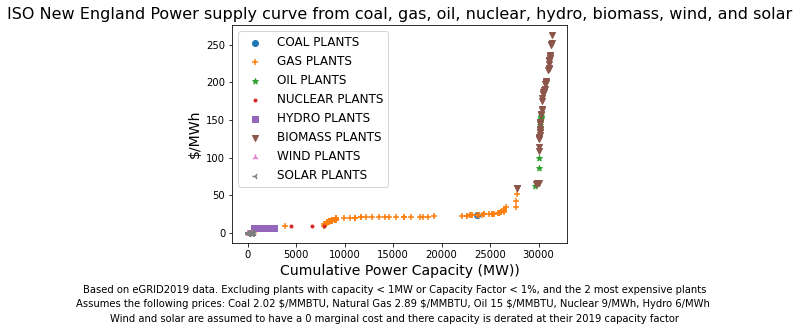

In [121]:
plt.scatter(coalSorted["CUMCAP"],coalSorted["MARGCOST"],marker="o",label="COAL PLANTS")
plt.scatter(gasSorted["CUMCAP"],gasSorted["MARGCOST"],marker="+",label="GAS PLANTS")
plt.scatter(oilSorted["CUMCAP"],oilSorted["MARGCOST"],marker="*",label="OIL PLANTS")
plt.scatter(nuclearSorted["CUMCAP"],nuclearSorted["MARGCOST"],marker=".",label="NUCLEAR PLANTS")
plt.scatter(hydroSorted["CUMCAP"],hydroSorted["MARGCOST"],marker="s",label="HYDRO PLANTS")
plt.scatter(bioSorted["CUMCAP"],bioSorted["MARGCOST"],marker="v",label="BIOMASS PLANTS")
plt.scatter(windSorted["CUMCAP"],windSorted["MARGCOST"],marker="2",label="WIND PLANTS")
plt.scatter(solarSorted["CUMCAP"],solarSorted["MARGCOST"],marker="3",label="SOLAR PLANTS")
plt.title(ISOName+" Power supply curve from coal, gas, oil, nuclear, hydro, biomass, wind, and solar",fontsize=16)
plt.xlabel("Cumulative Power Capacity (MW))", fontsize=14)
plt.ylabel("$/MWh",fontsize=14)
plt.legend(fontsize=12)
#Make sure to add a caption that makes this plot a stand-alone piece of information
txt="Based on eGRID2019 data. Excluding plants with capacity < 1MW or Capacity Factor < 1%, and the 2 most expensive plants"
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=10)
txt2="Assumes the following prices: Coal 2.02 $/MMBTU, Natural Gas 2.89 $/MMBTU, Oil 15 $/MMBTU, Nuclear 9/MWh, Hydro 6/MWh "
txt3="Wind and solar are assumed to have a 0 marginal cost and there capacity is derated at their 2019 capacity factor"
plt.figtext(0.5, -0.1, txt2, wrap=True, horizontalalignment='center', fontsize=10)
plt.figtext(0.5, -0.15, txt3, wrap=True, horizontalalignment='center', fontsize=10)
plt.show()